In [1]:
%load_ext autoreload
%autoreload 2

In [37]:
import os
import sys
import warnings

sys.path.append(os.path.join(os.path.abspath(''), '..', 'src'))
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import read_data
import process_data
import plot_data
import model

from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

# Case Ifood

## Summary

1. [Introduction](#1.-Introduction)
2. [Exploratory Data Analysis](#2.-Exploratory-Data-Analysis)
3. [Client Segmentation](#3.-Client-Segmentation)
4. [Classification](#4.-Classification)
5. [Results](#5.-Conclusion)
6. [References](#6.-References)

## 1. Introduction

The document's goal is to present the steps to achieve a solution for case proposed by Ifood.

Given a dataset on current customers from a retail food company, the challenge is to support the marketing team on choosing the right customers to offer a marketing campaign.

The requirements are listed bellow:

1. Provide the marketing team a better understanding of the characteristic features of respondents;
2. Create and describe a customer segmentation based on customers behaviors;
3. Create and describe a classification model which allows the company to maximize the profit of the next marketing campaign.

## 2. Exploratory Data Analysis

### Read the data

From the read Dataframe, we can see it contains 26 features and 2240 rows. A sample is show bellow:

In [3]:
df = read_data.read_data(
  filepath_or_buffer='../data/ml_project1_data.csv',
  index_col='ID',
)
df.head()

,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
ID,,,,,,,,,,,,,,,,,,,,,
5524,1957,Graduation,Single,58138.0,0,0,1346716800000000000,58,635,88,...,10,4,7,0,0,0,0,0,0,1
2174,1954,Graduation,Single,46344.0,1,1,1394236800000000000,38,11,1,...,1,2,5,0,0,0,0,0,0,0
4141,1965,Graduation,Together,71613.0,0,0,1377043200000000000,26,426,49,...,2,10,4,0,0,0,0,0,0,0
6182,1984,Graduation,Together,26646.0,1,0,1391990400000000000,26,11,4,...,0,4,6,0,0,0,0,0,0,0
5324,1981,PhD,Married,58293.0,1,0,1390089600000000000,94,173,43,...,3,6,5,0,0,0,0,0,0,0


Some fixes were applied:
1. There are columns that are read as integers but in reality are categorical.
2. There is a date column that is read as object.
3. There are 3 features that are not detailed in the data dictionary. The `Year_Birth` is kept since its meaning is clear, but the features `Z_CostContact` and `Z_Revenue` are dropped while there is not enough information about them.

In [4]:
print(f'Dataframe shape: {df.shape}')
print(f'Missing datapoints: {df.isnull().sum().sum()}')
print(df.info(memory_usage=False, show_counts=True))

Dataframe shape: (2240, 26)
Missing datapoints: 24
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2240 entries, 5524 to 9405
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   Year_Birth           2240 non-null   int64   
 1   Education            2240 non-null   category
 2   Marital_Status       2240 non-null   category
 3   Income               2216 non-null   float64 
 4   Kidhome              2240 non-null   int64   
 5   Teenhome             2240 non-null   int64   
 6   Dt_Customer          2240 non-null   int64   
 7   Recency              2240 non-null   int64   
 8   MntWines             2240 non-null   int64   
 9   MntFruits            2240 non-null   int64   
 10  MntMeatProducts      2240 non-null   int64   
 11  MntFishProducts      2240 non-null   int64   
 12  MntSweetProducts     2240 non-null   int64   
 13  MntGoldProds         2240 non-null   int64   
 14  NumDealsPurchases 

## Explore the data

From the information above, we can also see that the Dataframe is very complete, there are **only 24 missing values** on the whole Dataframe, all of them on the `Income` feature.

**No duplications** were identified when checking the index

In [5]:
df = df[~df.index.duplicated()]
print(f'There are {df.index.duplicated().sum()} duplicated rows')

There are 0 duplicated rows


**No zero variance** features were identified

In [6]:
print(f'There are {(df.var() == 0).sum()} zero variance features')

There are 0 zero variance features


From the table bellow we can see that the categorical columns are as expected. Most of the columns are boolean. The value counts from 'Education' and 'Marital_Status' are listed.

We can also see that the target is **imbalanced**, since approximately 1/4 from the customers accepted the last marketing campaign.

In [7]:
df.describe(include='category')

,Education,Marital_Status,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response
count,2240,2240,2240,2240,2240,2240,2240,2240,2240
unique,5,8,2,2,2,2,2,2,2
top,Graduation,Married,0,0,0,0,0,0,0
freq,1127,864,2077,2073,2077,2096,2210,2219,1906


In [8]:
print(df['Marital_Status'].value_counts(), '\n')
print(df['Education'].value_counts())

Married     864
Together    580
Single      480
Divorced    232
Widow        77
Alone         3
Absurd        2
YOLO          2
Name: Marital_Status, dtype: int64 

Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: Education, dtype: int64


The numerical columns show that there are some features that require further investigation on outliers presence. To avoid plotting one boxplot for each feature, we use interquartile distance to spot the outliers.

In [9]:
df.describe()

,Year_Birth,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth
count,2240.000000,2216.000000,2240.000000,2240.000000,2.240000e+03,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,1968.805804,52247.251354,0.444196,0.506250,1.373451e+18,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518
std,11.984069,25173.076661,0.538398,0.544538,1.746339e+16,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645
min,1893.000000,1730.000000,0.000000,0.000000,1.343606e+18,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1959.000000,35303.000000,0.000000,0.000000,1.358294e+18,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000
50%,1970.000000,51381.500000,0.000000,0.000000,1.373285e+18,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000
75%,1977.000000,68522.000000,1.000000,1.000000,1.388383e+18,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000
max,1996.000000,666666.000000,2.000000,2.000000,1.404000e+18,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000


From interquartile distance, we can see that **some features show outlier datapoints**. Treatment on null and outlier data points will be done later in this document.

In [10]:
process_data.find_outliers(df).sum()

Year_Birth               3
Income                   8
Kidhome                  0
Teenhome                 0
Dt_Customer              0
Recency                  0
MntWines                35
MntFruits              227
MntMeatProducts        175
MntFishProducts        223
MntSweetProducts       248
MntGoldProds           207
NumDealsPurchases       86
NumWebPurchases          4
NumCatalogPurchases     23
NumStorePurchases        0
NumWebVisitsMonth        8
dtype: int64

### Null values and Outliers Treatment

Null values and outliers can disturb the visualizations on the plotting step, then, before plotting the data, we remove these inconsistent datapoints.

First we transform all outliers into null values, then we use a K-Nearest Neighbor imputer, that, based on the nearest 5 neighbors, defines a new value for the null value.

In [11]:
df = process_data.knn_imput(df)

### Plot the data

First we want to see how the numerical features correlate.

From the plot, we can see that the feature `Income` positively correlates to most of the columns that show comsumption. 

AxesSubplot(0.127273,0.125;0.617727x0.755)


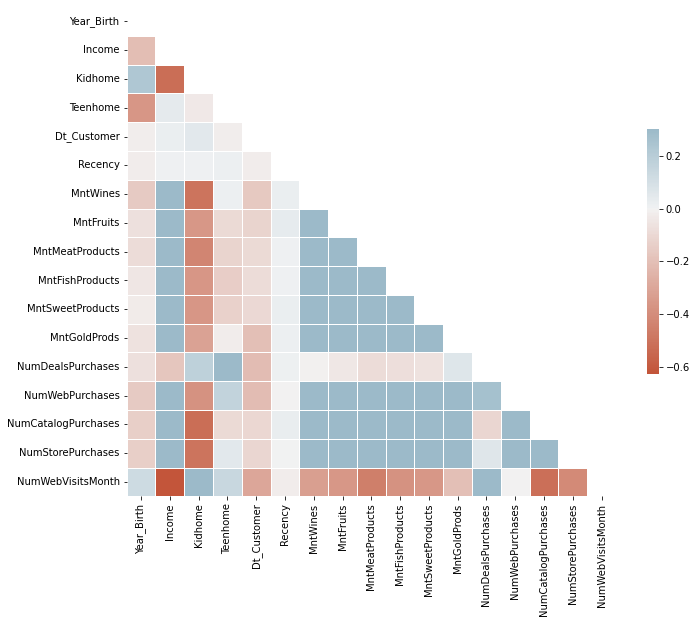

In [12]:
print(plot_data.plot_corr_matrix(df))

The `Income` feature is ploted grouped by `Response`. We can see that the customers whom accepted the last marketing offer tend to have higher income.

AxesSubplot(0.125,0.125;0.775x0.755)


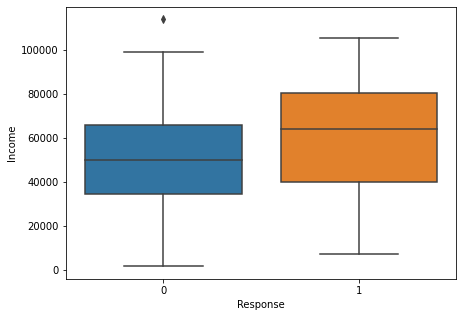

In [13]:
print(plot_data.plot_boxplot(df, 'Income'))

After grouping the data by `Response`, we plot the feature with the higher relative difference between the groups. This feature is `NumCatalogPurchases`.

AxesSubplot(0.125,0.125;0.775x0.755)


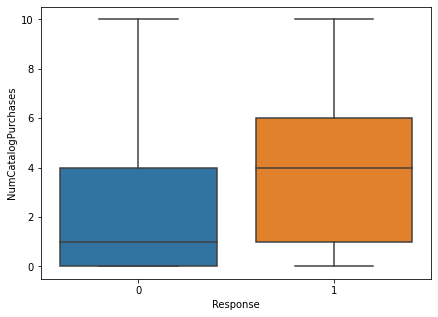

In [14]:
print(
  plot_data.plot_boxplot(
    df,
    process_data.calc_bigger_rel_diff_by_response(df),
  )
)

AxesSubplot(0.125,0.125;0.775x0.755)


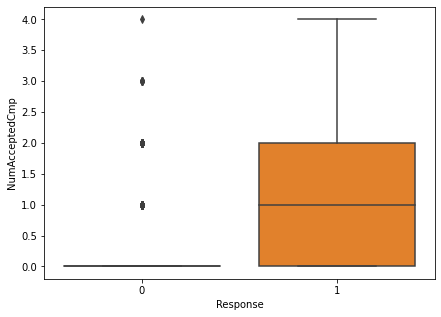

In [15]:
df = process_data.create_feature_accepted_any_cmp(df)
print(plot_data.plot_boxplot(df, 'NumAcceptedCmp'))

The customer group that accepted the last marketing campaign:

* Have higher income
* Have more purchases made using catalogue
* Had accepted marketing offers before

### 3. Client Segmentation

The client segmentation was done with the K-Means clustering algorithm. We fixed the amount of clusters in 3 and analysed the clusters based on the insights from the last section.

To start the clustering, it is necessary a preprocessing step, where we:
1. Apply One-Hot encoding to categorical features;
2. Drop low variance features;
3. Scale all the features.

In [20]:
x = process_data.preprocess(df)
clustered_df = process_data.kmeans_clustering(x)
grouped_clusters = clustered_df.groupby('Cluster').mean().reset_index()

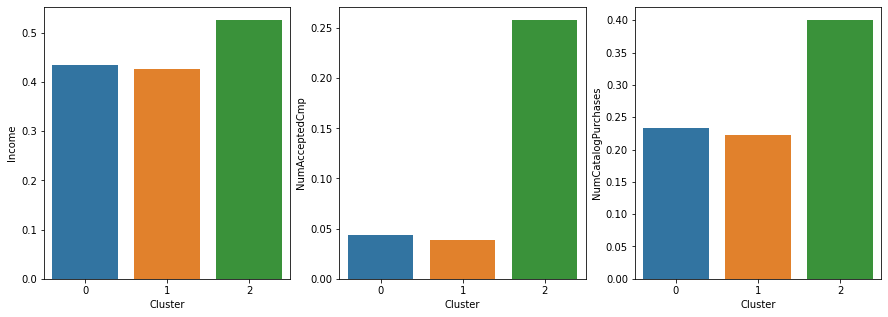

In [39]:
plot_data.plot_barplot_clusters(
  grouped_clusters,
  ['Income', 'NumAcceptedCmp', 'NumCatalogPurchases'],
).show()

From the grouping, we see that clusters `0` and `1` are very similar and cluster `2` consists of customers that have higher income, had accepted more offers and have a higher amount of purchases using the catalogue.

These results show that we want to advertise mostly for customers on cluster `2`, since their chances to accept the offer are bigger.

In [22]:
pca_df = process_data.calc_pca(x)
pca_df = pd.concat([pca_df, clustered_df['Cluster']], axis=1)

Figure(504x360)


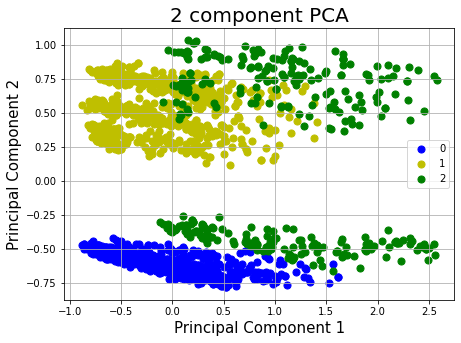

In [41]:
print(plot_data.plot_pca(pca_df))

### 4. Classification

### Explore different classification methods

To start the modeling it is necessary some additional treatment such as apply One-Hot encoding to categorical features, droping low variance features and scaling all the features.

As benchmark, we  used a Dummy Classifier which generates random predictions based on the training set class distribution.

We tested 4 algorithms: Decision Trees, Random Forests, K-Nearest Neighbors and Support Vector Machines. All algorithm tests were done using Cross Validation with Stratified Folds, to ensure trustful results even on imbalanced datasets.

The chosen score metric was balanced accuracy which is defined as the average of recall obtained on each class.

In [24]:
x = process_data.preprocess(df.drop(columns='Response'))
y = df['Response']

In [25]:
dummy = DummyClassifier(strategy='stratified', random_state=0)
dummy_results = model.eval_model(x, y, dummy)

rf = RandomForestClassifier(random_state=0)
rf_results = model.eval_model(x, y, rf)

dt = DecisionTreeClassifier(random_state=0)
dt_results = model.eval_model(x, y, dt)

svc = SVC(random_state=0)
svc_results = model.eval_model(x, y, svc)

knn = KNeighborsClassifier()
knn_results = model.eval_model(x, y, knn)

In [26]:
print(f'Dummy Classifier results:       Accuracy:{dummy_results[0]:.1%}, Balanced Accuracy: {dummy_results[1]:.1%}')
print(f'Random Forest results:          Accuracy:{rf_results[0]:.1%}, Balanced Accuracy: {rf_results[1]:.1%}')
print(f'Decision Trees results:         Accuracy:{dt_results[0]:.1%}, Balanced Accuracy: {dt_results[1]:.1%}')
print(f'Support Vector Machine results: Accuracy:{svc_results[0]:.1%}, Balanced Accuracy: {svc_results[1]:.1%}')
print(f'K-Nearest Neighbors results:    Accuracy:{knn_results[0]:.1%}, Balanced Accuracy: {knn_results[1]:.1%}')

Dummy Classifier results:       Accuracy:75.0%, Balanced Accuracy: 50.7%
Random Forest results:          Accuracy:88.2%, Balanced Accuracy: 66.9%
Decision Trees results:         Accuracy:84.8%, Balanced Accuracy: 70.3%
Support Vector Machine results: Accuracy:87.9%, Balanced Accuracy: 63.7%
K-Nearest Neighbors results:    Accuracy:86.7%, Balanced Accuracy: 63.5%


The obtained results show that Decision Trees have the best perfomance among the tested algorithms. Besides the perfomance, this algorithm has the advantage of a high explainability. On the next steps we make a deeper analysis on the Decision Tree model.

### Grid Search and Overfit analysis

Next, we want to tune the Decision Tree model, but also take into account if the model is overfitting.

In [27]:
params = {'max_depth': [i for i in range(1, 20)]}
grid_search = model.grid_search_model(x, y, DecisionTreeClassifier(), params)

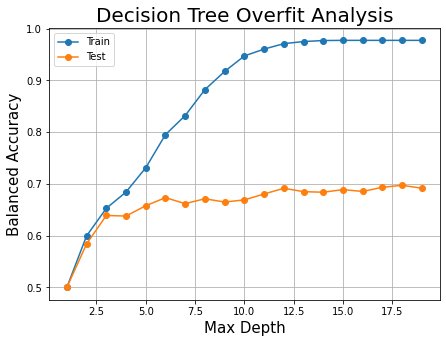

In [28]:
plot_data.plot_overfit_analysis(
  grid_search['param_max_depth'],
  grid_search['mean_train_score'],
  grid_search['mean_test_score'],
  'Max Depth',
  'Balanced Accuracy',
  'Decision Tree Overfit Analysis'
)

From the overfit analysis, we can see that Decision Trees with deepness greater than 3 tend to overfit the data.

Now we can define a final model for classification: A Decision Tree with maximum depth equal to 3, that results in a balanced accuracy of 64%.

### 5. Conclusion

On the first part of this document we made some explorations on the data and tried to extract some insights from the data manually.

Then, we proposed a method for client segmentation using K-Means clustering. The results in the section show which cluster is the most appropriate for the marketing campaign.

Finally, we explored different classification methods, taking into account Cross Validation, the unbalanced dataset, the model explainability and a proper evaluation metric. The choosen model was a Decision Tree with maximum depth of 3.

### 6. References

1. [Scikit Learn API](https://scikit-learn.org/stable/modules/classes.html)